In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS
# import wrds

# Data

In [2]:
raw = pd.read_excel("../data/raw.xlsx")
raw

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,Company Name,...,Short-Term Investments- Total,Current Liabilities - Total,Liabilities and Stockholders Equity - Total,Net Income (Loss) - Quarterly,Stockholders Equity - Total,Preferred Stock At Carrying Value - Utility,Capital Expenditures,Operating Activities - Net Cash Flow,Active/Inactive Status Marker,Standard Industry Classification Code
0,1045,1970-03-31,1970,1.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,-4.409,NaN,NaN,NaN,NaN,A,4512
1,1045,1970-06-30,1970,2.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,2.708,NaN,NaN,NaN,NaN,A,4512
2,1045,1970-09-30,1970,3.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,2.788,NaN,NaN,NaN,NaN,A,4512
3,1045,1970-12-31,1970,4.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,-27.485,379.022,NaN,NaN,NaN,A,4512
4,1045,1971-03-31,1971,1.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,-24.257,NaN,NaN,NaN,NaN,A,4512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177840,328795,2021-09-30,2021,3.0,INDL,C,D,STD,ACA,ARCOSA INC,...,0.0,389.4,3301.2,23.700,1940.900,NaN,60.8,76.8,A,3440
177841,328795,2021-12-31,2021,4.0,INDL,C,D,STD,ACA,ARCOSA INC,...,0.0,364.0,3188.1,9.200,1953.300,NaN,85.1,166.5,A,3440
177842,328795,2022-03-31,2022,1.0,INDL,C,D,STD,ACA,ARCOSA INC,...,0.0,403.7,3256.8,20.200,1977.600,NaN,25.9,24.5,A,3440
177843,328795,2022-06-30,2022,2.0,INDL,C,D,STD,ACA,ARCOSA INC,...,0.0,416.4,3337.3,39.000,1996.000,NaN,52.9,111.2,A,3440


In [3]:
# for those finance service companies
raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
                     raw["Stockholders Equity - Total"].shift()) * 1/2
raw["ave_asset"] = (raw['Assets - Total'] +
                    raw['Assets - Total'].shift()) * 1/2
raw["ave_equity"] = raw["ave_equity"].replace(0.0, np.nan)
raw["ave_asset"] = raw["ave_asset"].replace(0.0, np.nan)
# raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
# raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
#                                                 == 1]["Net Income (Loss)"]

# #####################################
# raw["NI_chg"] = raw["NI_chg"]
raw["ROA"] = raw["Net Income (Loss) - Quarterly"]/raw["ave_asset"]
raw["ROE"] = raw["Net Income (Loss) - Quarterly"]/raw["ave_equity"]

In [4]:
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
# raw["FCFROIC_ADJ"] = raw["FCFROIC_cal"].copy()
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC_ADJ"] = raw.loc[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]

In [8]:
raw_y = raw[raw["Fiscal Quarter"] == 4].copy()

In [9]:
raw_y["Year"] = raw_y["Fiscal Year"]

In [10]:
raw_y['Operating Activities - Net Cash Flow'] = raw_y['Operating Activities - Net Cash Flow'].fillna(raw_y['Operating Activities - Net Cash Flow'].rolling(5, min_periods=1).mean().shift())
raw_y['Capital Expenditures'] = raw_y['Capital Expenditures'].fillna(raw_y['Capital Expenditures'].rolling(5, min_periods=1).mean().shift())
raw_y["FCF"] = raw_y['Operating Activities - Net Cash Flow'] - \
    raw_y['Capital Expenditures']

In [ ]:
raw_y['Net Cash Flow'].fillna(raw_y['Net Cash Flow'].rolling(5, min_periods=1).mean().shift())

In [11]:
raw_y.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Industry Format',
       'Level of Consolidation - Company Interim Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'Company Name',
       'ISO Currency Code', 'Calendar Data Year and Quarter',
       'Fiscal Data Year and Quarter', 'Assets - Total',
       'Common/Ordinary Equity - Total', 'Cash and Short-Term Investments',
       'Cash', 'Debt in Current Liabilities', 'Long-Term Debt - Total',
       'Invested Capital - Total - Quarterly', 'Short-Term Investments- Total',
       'Current Liabilities - Total',
       'Liabilities and Stockholders Equity - Total',
       'Net Income (Loss) - Quarterly', 'Stockholders Equity - Total',
       'Preferred Stock At Carrying Value - Utility', 'Capital Expenditures',
       'Operating Activities - Net Cash Flow', 'Active/Inactive Status Marker',
       'Standard Industry Classification Code', 'ave_equity', 'ave_asset',
       'ROA', 'ROE

In [12]:
# Check data
raw_y.loc[raw_y["Operating Activities - Net Cash Flow"].isna(), ['Ticker Symbol', 'Operating Activities - Net Cash Flow', 'Capital Expenditures']]

,Ticker Symbol,Operating Activities - Net Cash Flow,Capital Expenditures
3,AAL,NaN,NaN
7,AAL,NaN,NaN
11,AAL,NaN,NaN
15,AAL,NaN,NaN
19,AAL,NaN,102.833
...,...,...,...
153850,EWBC,NaN,NaN
153854,EWBC,NaN,NaN
154275,CFFN,NaN,NaN
154279,CFFN,NaN,NaN


In [13]:
IC = pd.read_excel("../data/Total Invested Capital FactSet.xlsx", sheet_name=2)
IC = IC.merge(raw_y[["Year", "Ticker Symbol", 'Operating Activities - Net Cash Flow', 'Capital Expenditures', "FCF", "SIC", "ROE"]],
         how="left", on=["Year", "Ticker Symbol"])

In [14]:
IC["avg IC"] = (IC["Total Invested Capital (Calculated)"] + \
    IC["Total Invested Capital (Calculated)"].shift())/2
IC["avg IC"] = IC["avg IC"].replace(0.0, np.nan)
IC["FCFROIC"] = IC["FCF"]/IC["avg IC"]

# financial data
IC["FCFROIC_ADJ"] = IC["FCFROIC"]
IC.loc[(IC['SIC'] >= 6000) & (IC["SIC"] <= 6411), "FCFROIC_ADJ"] = IC.loc[(
    IC['SIC'] >= 6000) & (IC["SIC"] <= 6411), "ROE"]

IC.loc[(IC["avg IC"] < 0) & (IC["FCF"] > 0), "FCFROIC_ADJ"] = 1
IC.loc[(IC["avg IC"] < 0) & (IC["FCF"] < 0), "FCFROIC_ADJ"] = 0
IC["FCFROIC"].describe().to_excel("../clean_data/fcfroic_factset_0127.xlsx")

In [15]:
IC["ROE"].describe()

count    20204.000000
mean         0.011712
std          1.486479
min       -160.659794
25%          0.005698
50%          0.028061
75%          0.051531
max         77.770115
Name: ROE, dtype: float64

In [16]:
IC["FCFROIC"].describe()

count    29648.000000
mean         0.603636
std         25.110558
min       -836.741573
25%          0.006205
50%          0.074961
75%          0.167848
max       1893.259174
Name: FCFROIC, dtype: float64

In [17]:
IC["FCFROIC"].sort_values()[:10]

30718   -836.741573
40651   -359.384615
28720   -333.075269
45240   -312.841509
45238   -286.823741
40387   -243.736211
43794   -198.498258
38458   -176.849206
28719   -156.268398
45236   -150.799413
Name: FCFROIC, dtype: float64

In [18]:
IC["FCFROIC_ADJ"].describe()

count    31421.000000
mean         0.455267
std         22.888958
min       -836.741573
25%          0.008853
50%          0.064457
75%          0.150781
max       1893.259174
Name: FCFROIC_ADJ, dtype: float64

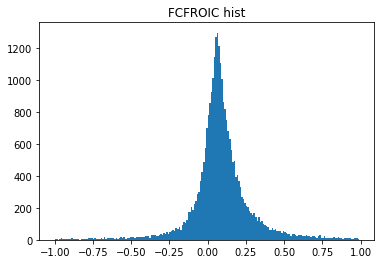

In [19]:
num = IC["FCFROIC"]
plt.hist(num, bins=np.arange(-1, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

In [24]:
grouped = IC.groupby('Ticker Symbol')
FCFROIC_ADJ = pd.DataFrame()
ls = []

for group in grouped:
    group = group[1].iloc[1:].copy()
    # use average to fill nan
    group["avg_fcfroic_min5"] = group[["FCFROIC"]].rolling(
        10, min_periods=5).mean()
    group["avg_fcfroic_5"] = group[["FCFROIC"]].rolling(5).mean()
    group["avg_fcfroic_7"] = group[["FCFROIC"]].rolling(7).mean()
    group["avg_fcfroic_expanding"] = group[["FCFROIC"]].expanding(
        10).mean().fillna(method="ffill")
    ls.append(group)
    # FCFROIC_ADJ = FCFROIC_ADJ.append(group, ignore_index=True)
FCFROIC_ADJ = pd.concat(ls, ignore_index=True)

In [25]:
FCFROIC_ADJ.to_excel("../clean_data/FCFROIC_ADJ_yearly_0127.xlsx")

In [23]:
FCFROIC_ADJ["avg_fcfroic_min5"].describe()

count    24913.000000
mean         0.627870
std         17.346478
min       -106.234841
25%          0.016732
50%          0.077647
75%          0.159836
max       1417.718489
Name: avg_fcfroic_min5, dtype: float64

In [28]:
FCFROIC_ADJ.groupby("Year").mean().to_excel("../clean_data/yearly_average_fcfroic.xlsx")

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_93541/2722582070.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FCFROIC_ADJ.groupby("Year").mean().to_excel("../clean_data/yearly_average_fcfroic.xlsx")


In [23]:
FCFROIC_ADJ["avg_fcfroic"].describe().to_excel("../clean_data/test.xlsx")

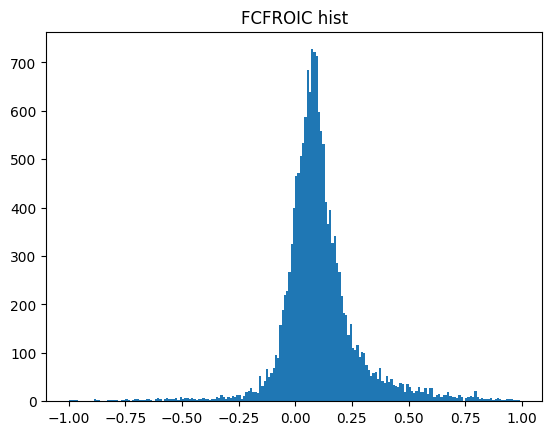

In [22]:
num = FCFROIC_ADJ["avg_fcfroic"]
plt.hist(num, bins=np.arange(-1, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

In [4]:
raw.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Industry Format',
       'Level of Consolidation - Company Interim Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'Company Name',
       'ISO Currency Code', 'Calendar Data Year and Quarter',
       'Fiscal Data Year and Quarter', 'Assets - Total',
       'Common/Ordinary Equity - Total', 'Cash and Short-Term Investments',
       'Cash', 'Debt in Current Liabilities', 'Long-Term Debt - Total',
       'Invested Capital - Total - Quarterly', 'Short-Term Investments- Total',
       'Current Liabilities - Total',
       'Liabilities and Stockholders Equity - Total', 'Net Income (Loss)',
       'Stockholders Equity - Total',
       'Preferred Stock At Carrying Value - Utility', 'Capital Expenditures',
       'Net Income (Loss).1', 'Operating Activities - Net Cash Flow',
       'Active/Inactive Status Marker',
       'Standard Industry Classification Code'],
      dtype='object')

In [5]:
raw[["Fiscal Year", "Capital Expenditures"]]

,Fiscal Year,Capital Expenditures
0,1970,NaN
1,1970,NaN
2,1970,NaN
3,1970,NaN
4,1971,NaN
...,...,...
177840,2021,60.8
177841,2021,85.1
177842,2022,25.9
177843,2022,52.9


## cal free cash flow

In [4]:
raw = pd.read_excel("../crsp_data/fundamental.xlsx")
raw

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,Company Name,...,Current Liabilities - Total,Liabilities and Stockholders Equity - Total,Net Income (Loss),Stockholders Equity - Total,Preferred Stock At Carrying Value - Utility,Capital Expenditures,Net Income (Loss).1,Operating Activities - Net Cash Flow,Active/Inactive Status Marker,Standard Industry Classification Code
0,1004,1970-02-28,1969,3.0,INDL,C,D,STD,AIR,AAR CORP,...,NaN,NaN,0.140,NaN,NaN,NaN,NaN,NaN,A,5080.0
1,1004,1970-05-31,1969,4.0,INDL,C,D,STD,AIR,AAR CORP,...,NaN,NaN,0.125,5.148,NaN,NaN,NaN,NaN,A,5080.0
2,1004,1970-08-31,1970,1.0,INDL,C,D,STD,AIR,AAR CORP,...,NaN,NaN,0.152,NaN,NaN,NaN,0.152,NaN,A,5080.0
3,1004,1970-11-30,1970,2.0,INDL,C,D,STD,AIR,AAR CORP,...,NaN,NaN,0.139,NaN,NaN,NaN,NaN,NaN,A,5080.0
4,1004,1971-02-28,1970,3.0,INDL,C,D,STD,AIR,AAR CORP,...,NaN,NaN,0.067,NaN,NaN,NaN,NaN,NaN,A,5080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263618,353444,2021-09-30,2021,3.0,INDL,C,D,STD,HLN,HALEON PLC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2834.0
263619,353444,2021-12-31,2021,4.0,INDL,C,D,STD,HLN,HALEON PLC,...,5739.0,46650.0,1204.000,35857.000,NaN,308.0,1882.000,1836.0,A,2834.0
263620,353444,2022-03-31,2022,1.0,INDL,C,D,STD,HLN,HALEON PLC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2834.0
263621,353444,2022-06-30,2022,2.0,INDL,C,D,STD,HLN,HALEON PLC,...,5102.0,54686.0,628.000,32806.000,NaN,95.0,628.000,826.0,A,2834.0


In [8]:
raw = raw[raw["Fiscal Quarter"] == 4].copy()

In [9]:
# for companies which do not have Capital Expenditures: nan --> 0

raw['Operating Activities - Net Cash Flow'] = raw['Operating Activities - Net Cash Flow'].fillna(raw['Operating Activities - Net Cash Flow'].rolling(5, min_periods=1).mean().shift())
raw['Capital Expenditures'] = raw['Capital Expenditures'].fillna(raw['Capital Expenditures'].rolling(5, min_periods=1).mean().shift())
raw["FCF"] = raw['Operating Activities - Net Cash Flow'] - \
    raw['Capital Expenditures']


## cal invested capital

In [10]:
def fillna(df, col_name):
    df[col_name] = df[col_name].fillna(0)
    return df


raw = fillna(raw, "Debt in Current Liabilities")
raw = fillna(raw, "Long-Term Debt - Total")
raw = fillna(raw, "Stockholders Equity - Total")
raw = fillna(raw, 'Cash and Short-Term Investments')

In [11]:
raw["IC_cal"] = raw["Debt in Current Liabilities"] + \
    raw["Long-Term Debt - Total"] + raw['Stockholders Equity - Total'] - \
    raw['Cash and Short-Term Investments']
raw["IC_cal"] = raw["IC_cal"].replace(0.0, np.nan)

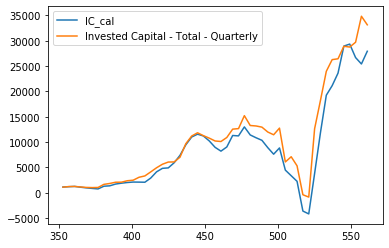

In [12]:
raw[raw["Ticker Symbol"] == "AAL"][[
    "IC_cal", "Invested Capital - Total - Quarterly"]].plot()

In [13]:
raw["pre_IC"] = raw["Invested Capital - Total - Quarterly"].shift()
raw["avg_IC"] = (raw["Invested Capital - Total - Quarterly"] + raw["pre_IC"])/2
raw["FCFROIC"] = raw["FCF"] / raw["avg_IC"]

In [14]:
raw["pre_IC_cal"] = raw["IC_cal"].shift()
raw["avg_IC_cal"] = (raw["IC_cal"] + raw["pre_IC_cal"])/2
# raw["avg_IC_cal"] = raw["avg_IC_cal"].replace(0.0, np.nan)

raw["FCFROIC_cal"] = raw["FCF"]/raw["avg_IC_cal"]  # 3

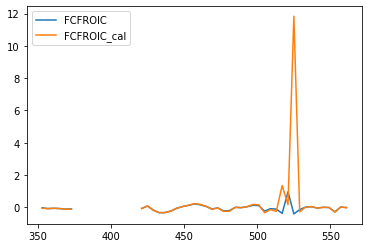

In [15]:
raw[raw["Ticker Symbol"] == "AAL"][[
    "FCFROIC", "FCFROIC_cal"]].plot()

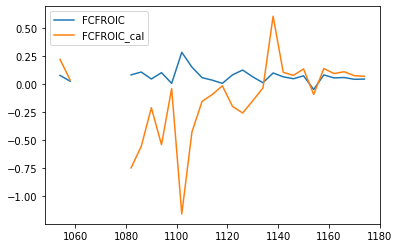

In [16]:
raw[raw["Ticker Symbol"] == "AVX"][[
    "FCFROIC", "FCFROIC_cal"]].plot()

## cal financial industry roe

In [17]:
# for those finance service companies
raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
                     raw["Stockholders Equity - Total"].shift()) * 1/2
raw["ave_asset"] = (raw['Assets - Total'] +
                    raw['Assets - Total'].shift()) * 1/2
raw["ave_equity"] = raw["ave_equity"].replace(0.0, np.nan)
raw["ave_asset"] = raw["ave_asset"].replace(0.0, np.nan)
# raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
# raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
#                                                 == 1]["Net Income (Loss)"]

# #####################################
# raw["NI_chg"] = raw["NI_chg"]
raw["ROA"] = raw["Net Income (Loss)"]/raw["ave_asset"]
raw["ROE"] = raw["Net Income (Loss)"]/raw["ave_equity"]

In [18]:
raw['Standard Industry Classification Code']

1         5080.0
5         5080.0
9         5080.0
13        5080.0
17        5080.0
           ...  
263594    3440.0
263601    7310.0
263608    7374.0
263612    7374.0
263619    2834.0
Name: Standard Industry Classification Code, Length: 64626, dtype: float64

In [19]:
raw = raw.dropna(subset=["Standard Industry Classification Code"]).copy()
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
raw["FCFROIC_ADJ"] = raw["FCFROIC_cal"].copy()
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC_ADJ"] = raw.loc[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC"] = raw.loc[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]

In [20]:
raw.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Industry Format',
       'Level of Consolidation - Company Interim Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'Company Name',
       'ISO Currency Code', 'Calendar Data Year and Quarter',
       'Fiscal Data Year and Quarter', 'Assets - Total',
       'Common/Ordinary Equity - Total', 'Cash and Short-Term Investments',
       'Cash', 'Debt in Current Liabilities', 'Long-Term Debt - Total',
       'Invested Capital - Total - Quarterly', 'Short-Term Investments- Total',
       'Current Liabilities - Total',
       'Liabilities and Stockholders Equity - Total', 'Net Income (Loss)',
       'Stockholders Equity - Total',
       'Preferred Stock At Carrying Value - Utility', 'Capital Expenditures',
       'Net Income (Loss).1', 'Operating Activities - Net Cash Flow',
       'Active/Inactive Status Marker',
       'Standard Industry Classification Code', 'FCF', 'IC_cal', 'pre_IC',


In [21]:
fcfroic = raw[["Fiscal Year", "Fiscal Quarter",
               "Ticker Symbol", "Debt in Current Liabilities", "Long-Term Debt - Total", "Stockholders Equity - Total", "Cash and Short-Term Investments", 
               "IC_cal", "Invested Capital - Total - Quarterly",
               'Operating Activities - Net Cash Flow', 'Capital Expenditures', "FCF", "FCFROIC", "FCFROIC_cal", 
               "ROE", "FCFROIC_ADJ", 
               "Standard Industry Classification Code"]]
fcfroic.to_excel("../clean_data/fcfroic/fcfroic_0210.xlsx")

# functions

In [ ]:
def rmv_outliner(data, method="3sigma", lo_q=0.01, hi_q=0.99, fill="delete"):
    '''
    remove outliner
    '''
    if method == "3sigma":
        _h = data.mean() + 3*data.std()
        _l = data.mean() - 3*data.std()
    elif method == "quantile":
        q = data.quantile([lo_q, hi_q])
        _l = q.iloc[0]
        _h = q.iloc[1]

    if fill == "delete":
        for colname in data.columns:
            data = data.copy()
            data = data[(data[colname] < _h[colname]) &
                        (data[colname] > _l[colname])]

    return data

# Calculation

In [39]:
raw_y = raw[raw["Fiscal Quarter"] == 4].copy()

In [40]:
grouped = raw_y.groupby('Global Company Key')
FCFROIC_ADJ = pd.DataFrame(columns=["Global Company Key", "Data Date",
                                    "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC", "FCFROIC_ADJ"])
ls = []
for group in grouped:
    group = group[1].iloc[1:][["Global Company Key", "Data Date",
                               "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC", "FCFROIC_ADJ"]].copy()
    group = group.sort_values(by="Data Date")
    group["avg_fcfroic_min5"] = group[["FCFROIC"]].rolling(
        10, min_periods=5).mean()
    group["avg_fcfroic_5"] = group[["FCFROIC"]].rolling(5).mean()
    group["avg_fcfroic_7"] = group[["FCFROIC"]].rolling(7).mean()
    group["avg_fcfroic"] = group[["FCFROIC"]].rolling(
        10).mean()
    
    group["avg_fcfroic_cal_min5"] = group[["FCFROIC_ADJ"]].rolling(
        10, min_periods=5).mean()
    group["avg_fcfroic_cal_5"] = group[["FCFROIC_ADJ"]].rolling(5).mean()
    group["avg_fcfroic_cal_7"] = group[["FCFROIC_ADJ"]].rolling(7).mean()
    group["avg_fcfroic_cal"] = group[["FCFROIC_ADJ"]].rolling(
        10).mean()
    ls.append(group)
    # FCFROIC_ADJ = FCFROIC_ADJ.append(group, ignore_index=True)
FCFROIC_ADJ = pd.concat(ls, ignore_index=True)

In [45]:
FCFROIC_ADJ[["avg_fcfroic", "avg_fcfroic_cal"]].describe()

,avg_fcfroic,avg_fcfroic_cal
count,24012.000000,24049.000000
mean,0.072649,0.164714
std,1.848345,9.026134
min,-59.368264,-159.328164
25%,0.015197,-0.021766
50%,0.060593,0.062585
75%,0.113217,0.173656
max,195.023776,563.316819


In [47]:
FCFROIC_ADJ

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,FCFROIC_ADJ,avg_fcfroic_min5,avg_fcfroic_5,avg_fcfroic_7,avg_fcfroic,avg_fcfroic_cal_min5,avg_fcfroic_cal_5,avg_fcfroic_cal_7,avg_fcfroic_cal
0,1004,1971-05-31,1970,4.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1004,1972-05-31,1971,4.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1004,1973-05-31,1972,4.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1004,1974-05-31,1973,4.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1004,1975-05-31,1974,4.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61590,328795,2018-12-31,2018,4.0,ACA,0.045054,0.046591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61591,328795,2019-12-31,2019,4.0,ACA,0.144107,0.158797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61592,328795,2020-12-31,2020,4.0,ACA,0.082630,0.088033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61593,328795,2021-12-31,2021,4.0,ACA,0.030491,0.031091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


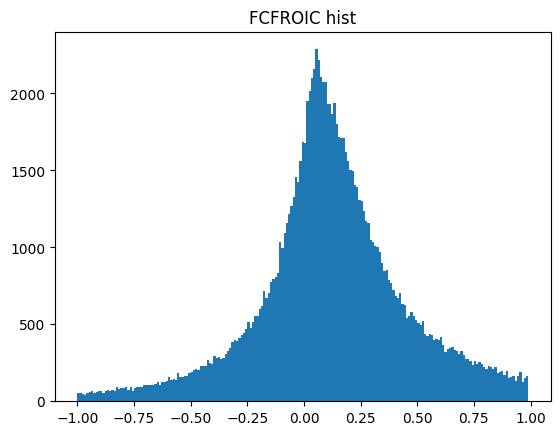

In [20]:
num = FCFROIC_ADJ["FCFROIC_cal"]
plt.hist(num, bins=np.arange(-1, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

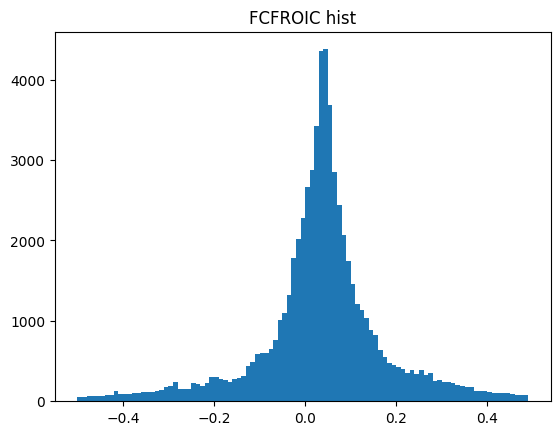

In [ ]:
num = FCFROIC_ADJ["avg_fcfroic"]
plt.hist(num, bins=np.arange(-0.5, 0.5, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/10y average FCFROIC hist.png")
plt.show()

In [46]:
his_mean = FCFROIC_ADJ.groupby("Data Date").mean()
data = his_mean["avg_fcfroic"].dropna()
data.to_excel("../clean_data/historical_mean_fcfroic.xlsx")

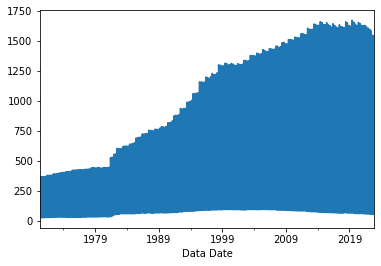

In [30]:
his_num = FCFROIC_ADJ.groupby("Data Date").count()
his_num["Global Company Key"].dropna().plot()

In [31]:
FCFROIC_ADJ.to_excel("../clean_data/FCFROIC_ADJ_0109.xlsx")

In [41]:
FCFROIC_ADJ.to_excel("../clean_data/FCFROIC_ADJ_YEARLY_0109.xlsx")

In [ ]:
grouped = FCFROIC_ADJ.groupby("Data Date")


In [33]:
FCFROIC_ADJ

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,FCFROIC_ADJ,avg_fcfroic_min5,avg_fcfroic_5,avg_fcfroic_7,avg_fcfroic,avg_fcfroic_cal_min5,avg_fcfroic_cal_5,avg_fcfroic_cal_7,avg_fcfroic_cal
0,1004,1970-05-31,1969,4.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1004,1970-08-31,1970,1.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1004,1970-11-30,1970,2.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1004,1971-02-28,1970,3.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1004,1971-05-31,1970,4.0,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260567,353444,2021-09-30,2021,3.0,HLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260568,353444,2021-12-31,2021,4.0,HLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260569,353444,2022-03-31,2022,1.0,HLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260570,353444,2022-06-30,2022,2.0,HLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
